In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import holidays
import matplotlib.dates as mdates
import scipy
sns.set_theme()
sns.set_style("ticks")
semana=["Lunes","Martes","Miercoles","Jueves","Viernes","Sabado","Domingo"]


In [2]:
_df = pd.read_csv("https://valencia.opendatasoft.com/api/explore/v2.1/catalog/datasets/rvvcca_d_horarios_2021-2022/exports/csv?lang=es&timezone=Europe%2FBerlin&use_labels=true&delimiter=%3B",delimiter=";")

# Limpiar malas lecturas
_df = _df[_df["Temperatura"] < 45]
_df = _df[_df["Precipitacion"] < 300]

# Columnas temporales
_df["Hora"] = _df["Hora"].apply(lambda x : x[11:16])
_df["time"] = _df["Fecha"] + "T" +_df["Hora"]
_df["time"] = pd.to_datetime(_df["time"])
_df["Month"] = _df["time"].dt.month
_df.drop(columns=["Fecha baja","Fecha creacion"],inplace=True)

_df.set_index("time",inplace=True)
_df.sort_index(inplace=True)


# Fin de semana
_df["Dia de la semana numerico"] = _df.index.to_series().dt.weekday
_df["weekend"] = _df["Dia de la semana numerico"] >= 5

# Festivos
es_holidays = holidays.ES()
_df["holidays"] = _df["Fecha"].apply(lambda x : x in es_holidays)
_df["weekend or holidays"] = _df["weekend"] | _df["holidays"]

# Hora en formato datetime
_df["timedelta"] = pd.to_datetime(_df["Hora"])

# Estación por mes
season_map = {1:"Invierno",
              2:"Invierno",
              12:"Invierno",
              3:"Primavera",
              4:"Primavera",
              5:"Primavera",
              6:"Verano",
              7:"Verano",
              8:"Verano",
              9:"Otoño",
              10:"Otoño",
              11:"Otoño",}
_df["Season"] = _df["Month"].map(season_map)


/tmp/ipykernel_14880/1854711584.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _df["timedelta"] = pd.to_datetime(_df["Hora"])


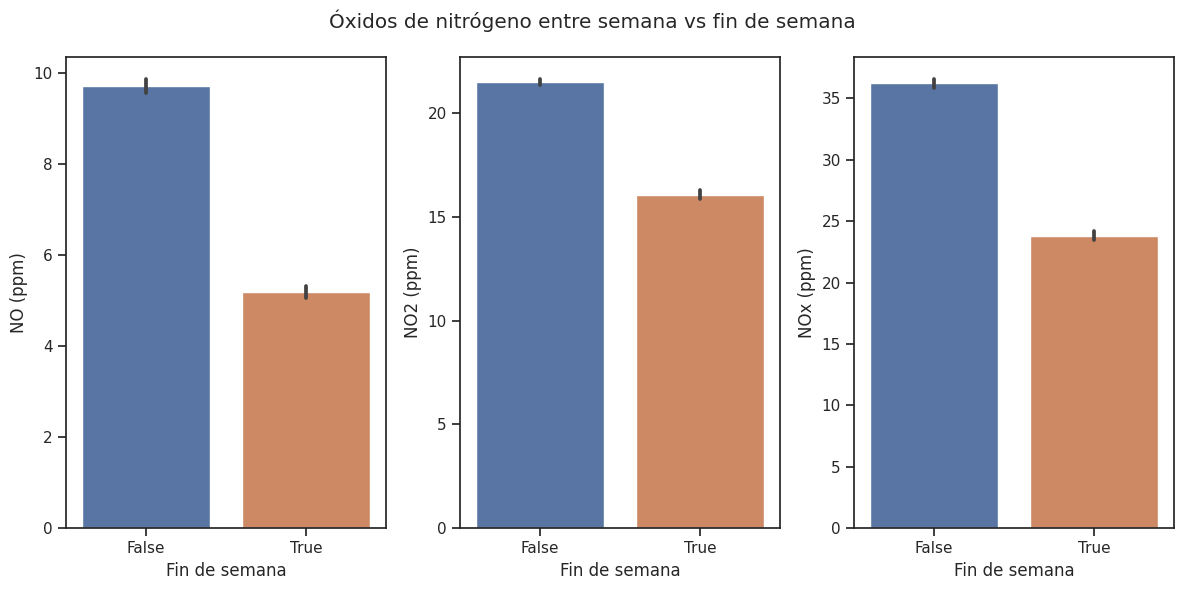

In [3]:
fig, (ax,ax1,ax2) = plt.subplots(figsize=(12,6),ncols=3)
fig.suptitle("Óxidos de nitrógeno entre semana vs fin de semana")

sns.barplot(_df,x="weekend",y="NO",ax=ax)
sns.barplot(_df,x="weekend",y="NO2",ax=ax1)
sns.barplot(_df,x="weekend",y="NOx",ax=ax2)

ax.set_xlabel("Fin de semana")
ax1.set_xlabel("Fin de semana")
ax2.set_xlabel("Fin de semana")

ax.set_ylabel("NO (ppm)")
ax1.set_ylabel("NO2 (ppm)")
ax2.set_ylabel("NOx (ppm)")
fig.tight_layout()
plt.savefig("results/bar_oxidos_nitrogeno.svg")
plt.show()

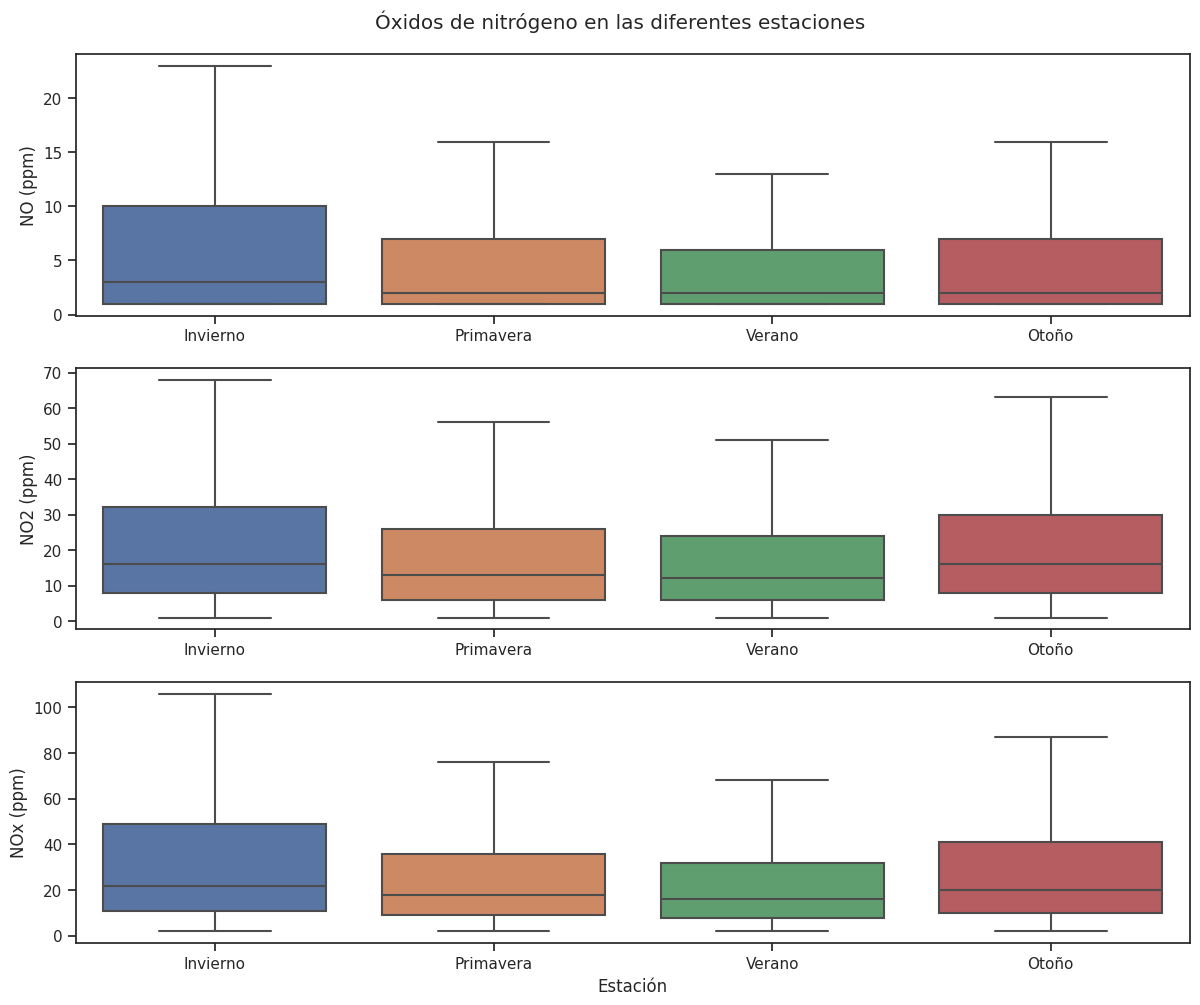

In [4]:
# Boxplot: Óxidos de nitrógeno en las diferentes estaciones
fig, (ax,ax1,ax2) = plt.subplots(figsize=(12,10),nrows=3)
fig.suptitle("Óxidos de nitrógeno en las diferentes estaciones")
fig.tight_layout()
sns.boxplot(_df,y="NO",x="Season",ax=ax,showfliers=False)
sns.boxplot(_df,y="NO2",x="Season",ax=ax1,showfliers=False)
sns.boxplot(_df,y="NOx",x="Season",ax=ax2,showfliers=False)

ax.set_xlabel("")
ax1.set_xlabel("")
ax2.set_xlabel("Estación")

ax.set_ylabel("NO (ppm)")
ax1.set_ylabel("NO2 (ppm)")
ax2.set_ylabel("NOx (ppm)")
plt.savefig("results/box_oxide_nitrogen_thru_season.svg")

plt.show()

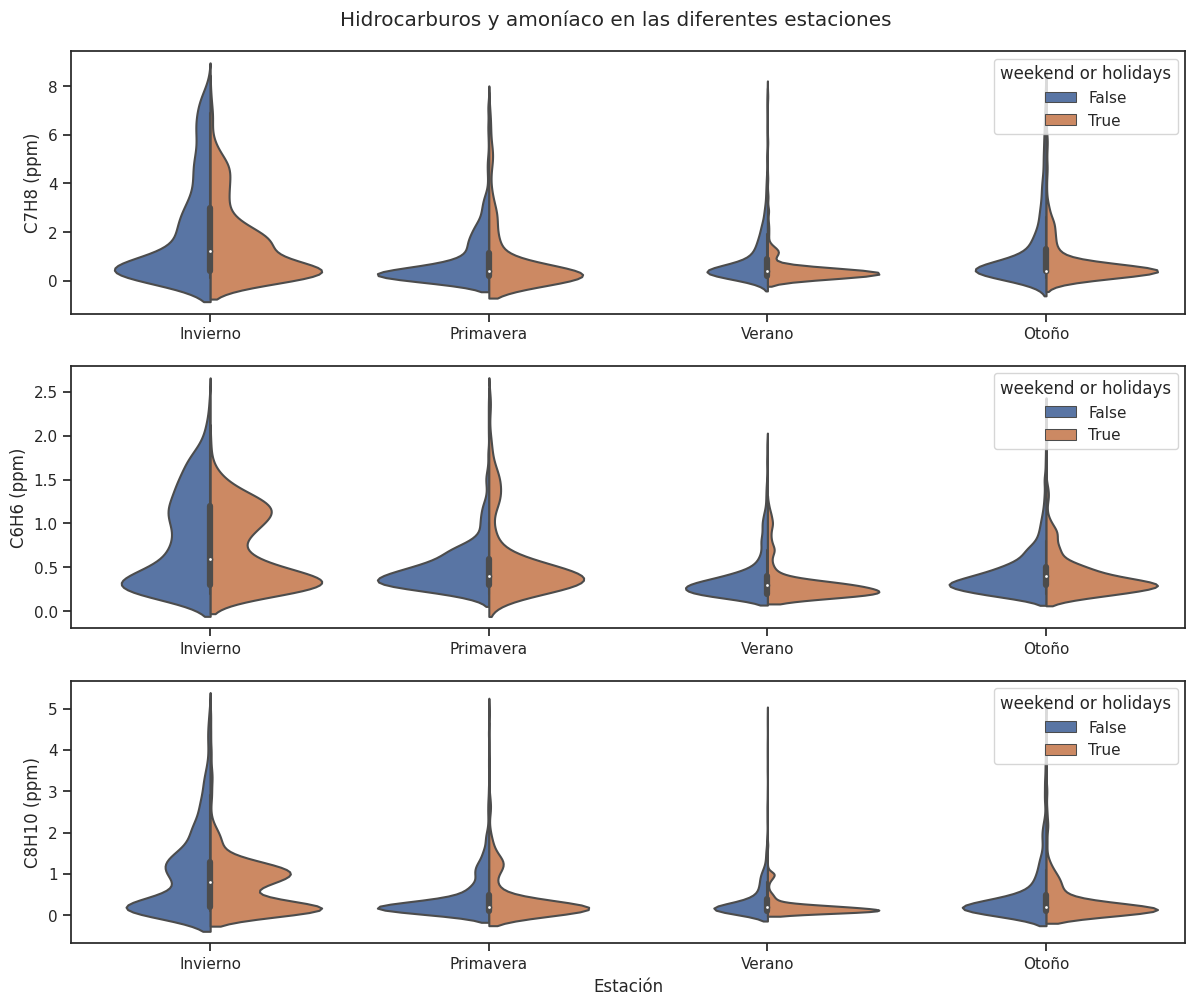

In [5]:
# Violinplot: Hidrocarburos y amoníaco en las diferentes estaciones
fig, (ax1,ax2,ax3) = plt.subplots(figsize=(12,10),nrows=3)
fig.suptitle("Hidrocarburos y amoníaco en las diferentes estaciones")
fig.tight_layout()

sns.violinplot(_df[_df["C7H8"] < 8],y="C7H8",x="Season",ax=ax1,showfliers=False,hue="weekend or holidays",split=True)
sns.violinplot(_df[_df["C6H6"] < 2.5],y="C6H6",x="Season",ax=ax2,showfliers=False,hue="weekend or holidays",split=True)
sns.violinplot(_df[_df["C8H10"] < 5],y="C8H10",x="Season",ax=ax3,showfliers=False,hue="weekend or holidays",split=True)

ax1.set_xlabel("")
ax2.set_xlabel("")
ax3.set_xlabel("Estación")


ax1.set_ylabel("C7H8 (ppm)")
ax2.set_ylabel("C6H6 (ppm)")
ax3.set_ylabel("C8H10 (ppm)")
plt.savefig("results/violin_hydrocarbon_ammonia_thru_seasons.svg")

plt.show()

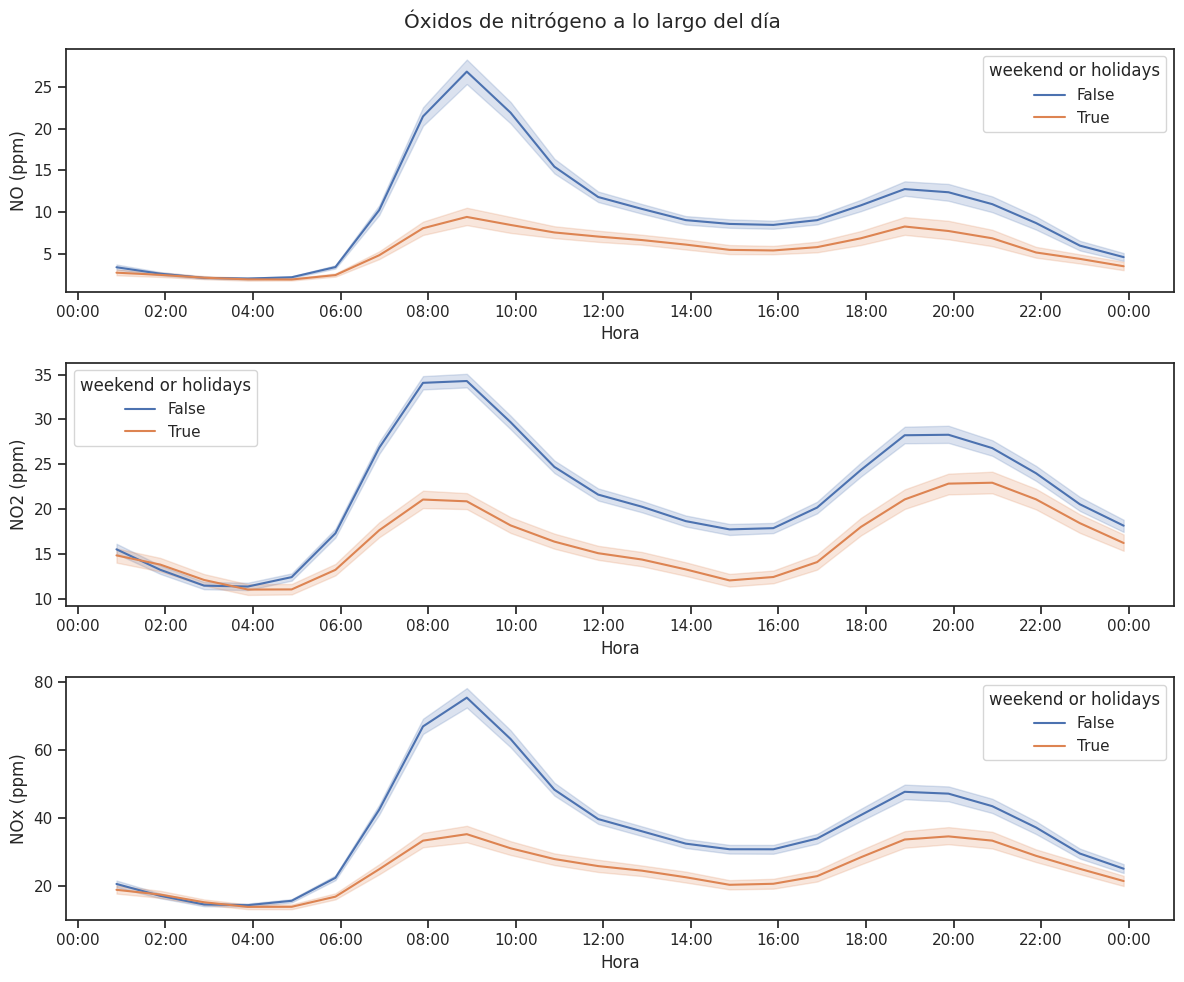

In [6]:
# Lineplot: Óxidos de nitrógeno a lo largo del día
fig, (ax,ax1,ax2) = plt.subplots(figsize=(12,10),nrows=3)
fig.suptitle("Óxidos de nitrógeno a lo largo del día")

sns.lineplot(_df.reset_index(),x="timedelta",y="NO",ax=ax,hue="weekend or holidays")
sns.lineplot(_df.reset_index(),x="timedelta",y="NO2",ax=ax1,hue="weekend or holidays")
sns.lineplot(_df.reset_index(),x="timedelta",y="NOx",ax=ax2,hue="weekend or holidays")

ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
ax1.xaxis.set_major_locator(mdates.HourLocator(interval=2))
ax2.xaxis.set_major_locator(mdates.HourLocator(interval=2))
# set formatter
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

ax.set_xlabel("Hora")
ax1.set_xlabel("Hora")
ax2.set_xlabel("Hora")

ax.set_ylabel("NO (ppm)")
ax1.set_ylabel("NO2 (ppm)")
ax2.set_ylabel("NOx (ppm)")

fig.tight_layout()
plt.savefig("results/line_oxide_nitrogen_thru_day.svg")
plt.show()


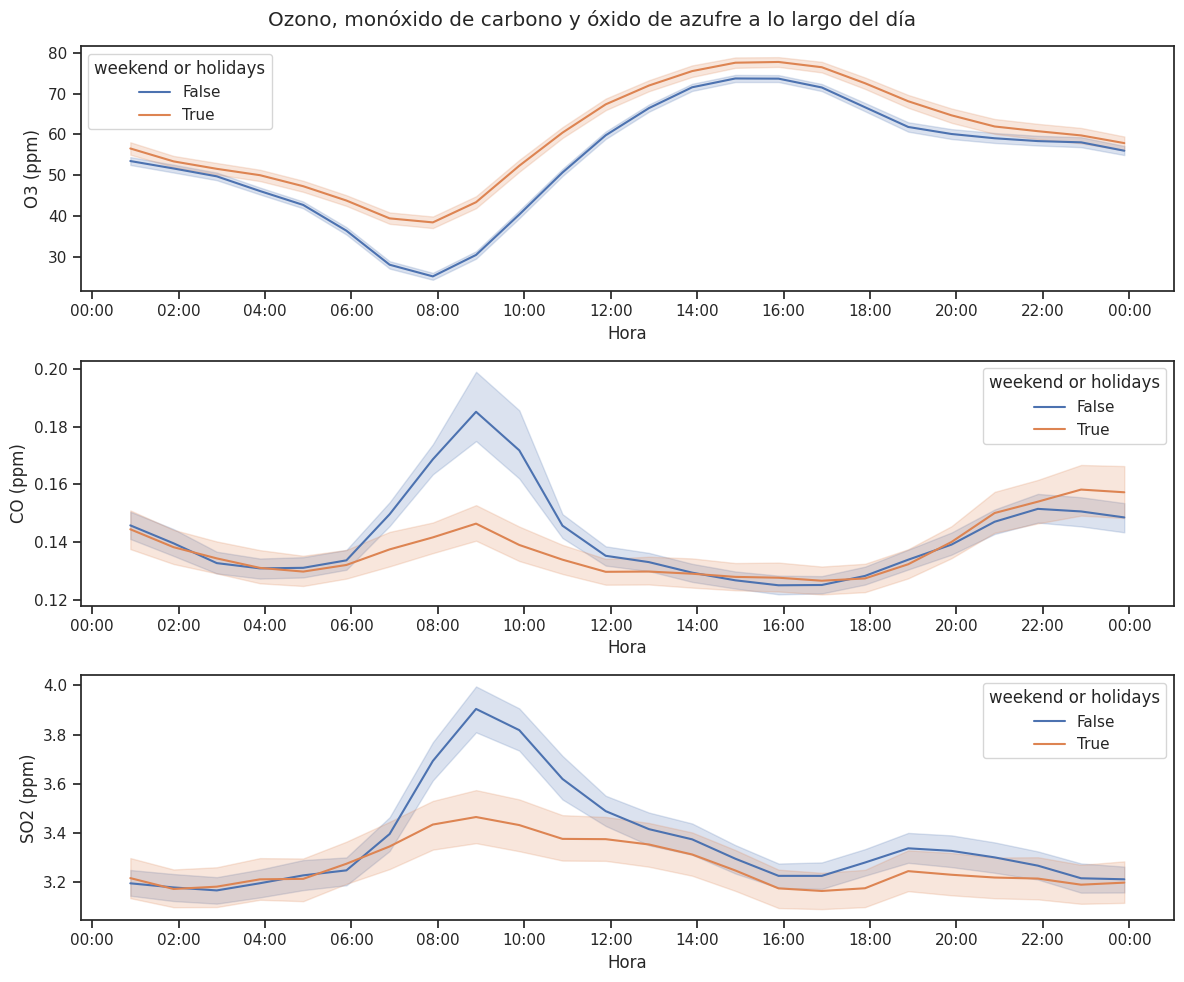

In [7]:
# Lineplot: Ozono, moóxido y óxido de azufre a lo largo del día
fig, (ax,ax1,ax2) = plt.subplots(figsize=(12,10),nrows=3)
fig.suptitle("Ozono, monóxido de carbono y óxido de azufre a lo largo del día")

sns.lineplot(_df.reset_index(),x="timedelta",y="O3",ax=ax,hue="weekend or holidays")
sns.lineplot(_df.reset_index(),x="timedelta",y="CO",ax=ax1,hue="weekend or holidays")
sns.lineplot(_df.reset_index(),x="timedelta",y="SO2",ax=ax2,hue="weekend or holidays")

ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
ax1.xaxis.set_major_locator(mdates.HourLocator(interval=2))
ax2.xaxis.set_major_locator(mdates.HourLocator(interval=2))
# set formatter
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

ax.set_xlabel("Hora")
ax1.set_xlabel("Hora")
ax2.set_xlabel("Hora")

ax.set_ylabel("O3 (ppm)")
ax1.set_ylabel("CO (ppm)")
ax2.set_ylabel("SO2 (ppm)")

fig.tight_layout()
plt.savefig("results/line_o3_co_so2_thru_day.svg")

plt.show()

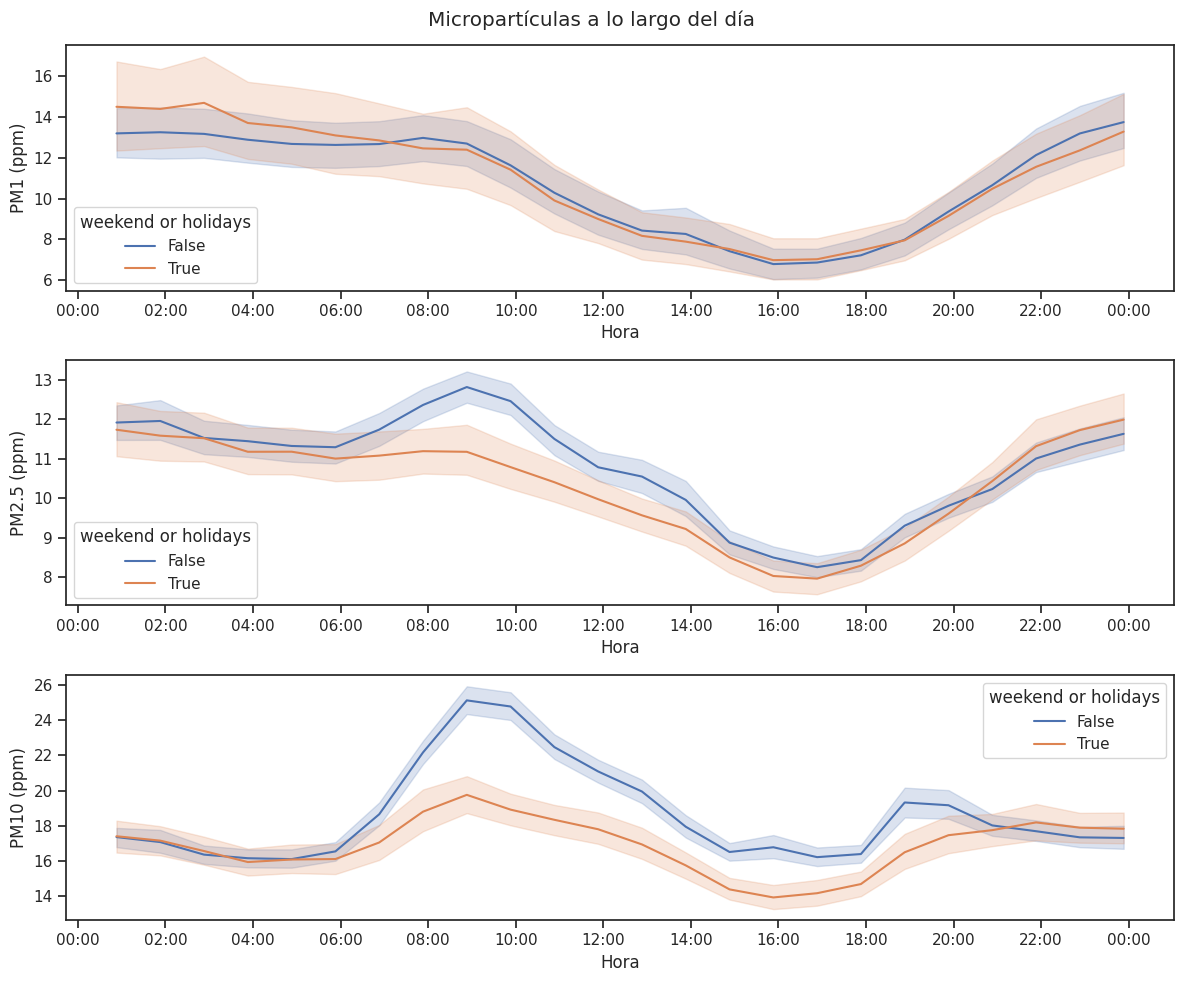

In [8]:
# Lineplot: Micropartículas a lo largo del día
fig, (ax,ax1,ax2) = plt.subplots(figsize=(12,10),nrows=3)
fig.suptitle("Micropartículas a lo largo del día")
sns.lineplot(_df.reset_index(),x="timedelta",y="PM1",ax=ax,hue="weekend or holidays")
sns.lineplot(_df.reset_index(),x="timedelta",y="PM2.5",ax=ax1,hue="weekend or holidays")
sns.lineplot(_df.reset_index(),x="timedelta",y="PM10",ax=ax2,hue="weekend or holidays")

ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
ax1.xaxis.set_major_locator(mdates.HourLocator(interval=2))
ax2.xaxis.set_major_locator(mdates.HourLocator(interval=2))
# set formatter
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

ax.set_xlabel("Hora")
ax1.set_xlabel("Hora")
ax2.set_xlabel("Hora")

ax.set_ylabel("PM1 (ppm)")
ax1.set_ylabel("PM2.5 (ppm)")
ax2.set_ylabel("PM10 (ppm)")

fig.tight_layout()
plt.savefig("results/line_particles_thru_day.svg")

plt.show()


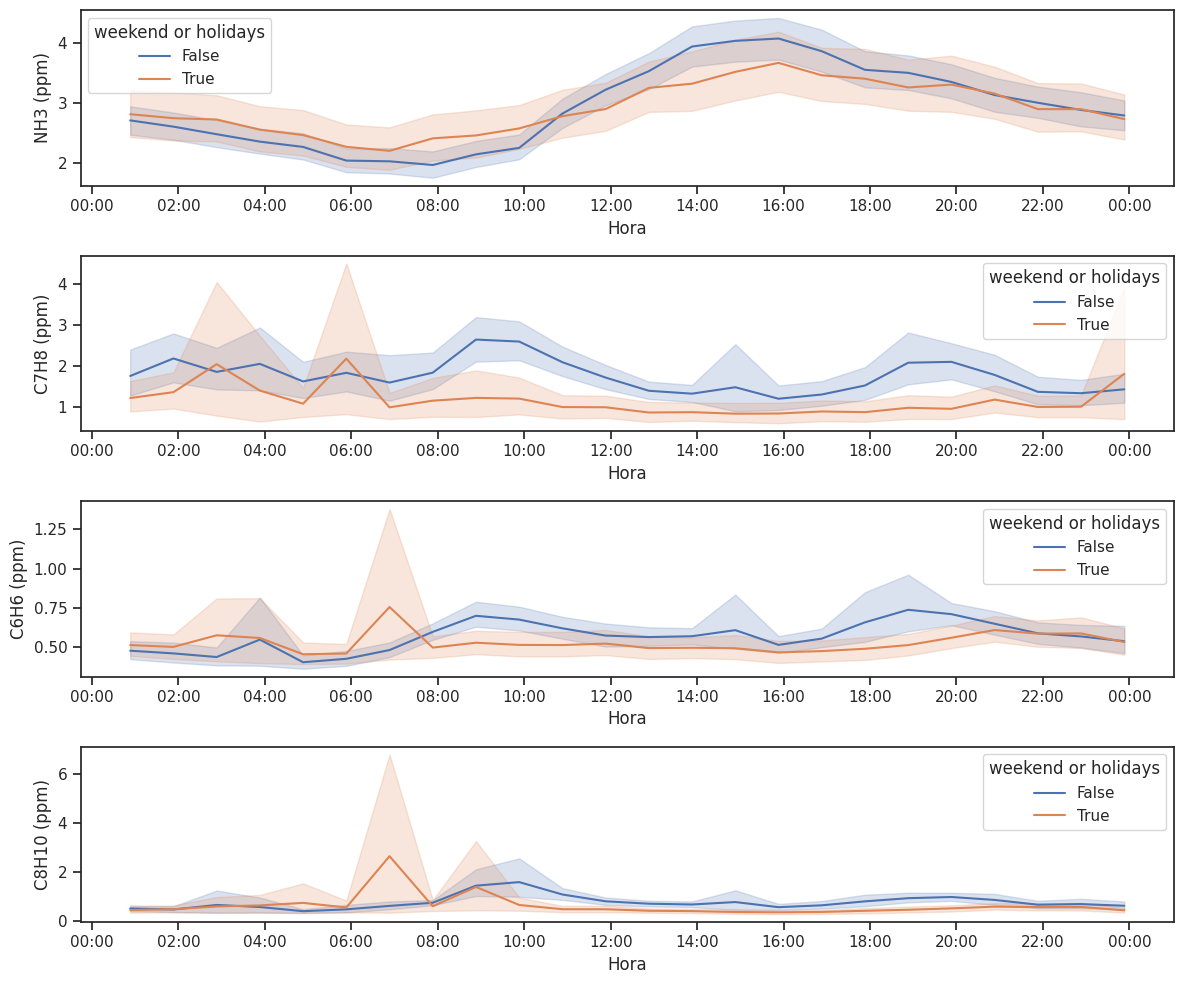

In [9]:
fig, (ax,ax1,ax2,ax3) = plt.subplots(figsize=(12,10),nrows=4)
sns.lineplot(_df.reset_index(),x="timedelta",y="NH3",ax=ax,hue="weekend or holidays")
sns.lineplot(_df.reset_index(),x="timedelta",y="C7H8",ax=ax1,hue="weekend or holidays")
sns.lineplot(_df.reset_index(),x="timedelta",y="C6H6",ax=ax2,hue="weekend or holidays")
sns.lineplot(_df.reset_index(),x="timedelta",y="C8H10",ax=ax3,hue="weekend or holidays")

ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
ax1.xaxis.set_major_locator(mdates.HourLocator(interval=2))
ax2.xaxis.set_major_locator(mdates.HourLocator(interval=2))
ax3.xaxis.set_major_locator(mdates.HourLocator(interval=2))
# set formatter
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

ax.set_xlabel("Hora")
ax1.set_xlabel("Hora")
ax2.set_xlabel("Hora")
ax3.set_xlabel("Hora")

ax.set_ylabel("NH3 (ppm)")
ax1.set_ylabel("C7H8 (ppm)")
ax2.set_ylabel("C6H6 (ppm)")
ax3.set_ylabel("C8H10 (ppm)")

fig.tight_layout()
plt.savefig("results/line_hidrocarbons_ammonia.svg")
plt.show()

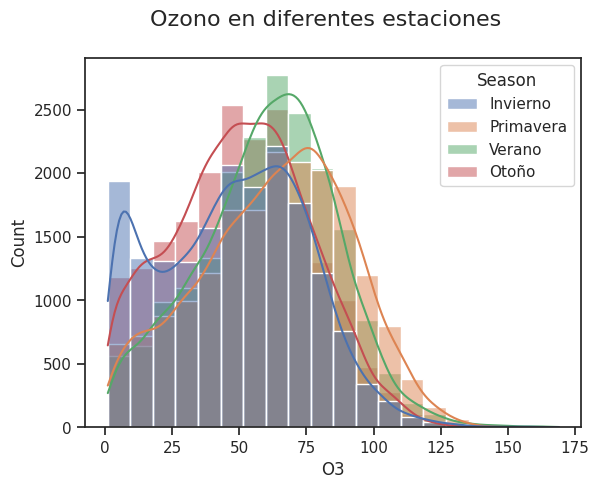

In [10]:
g = sns.histplot(_df.reset_index(),x="O3",bins=20,hue="Season",kde=True,multiple="layer")
plt.suptitle('Ozono en diferentes estaciones', fontsize=16)
plt.savefig("results/hist_o3_tru_seasons.svg")

plt.show()

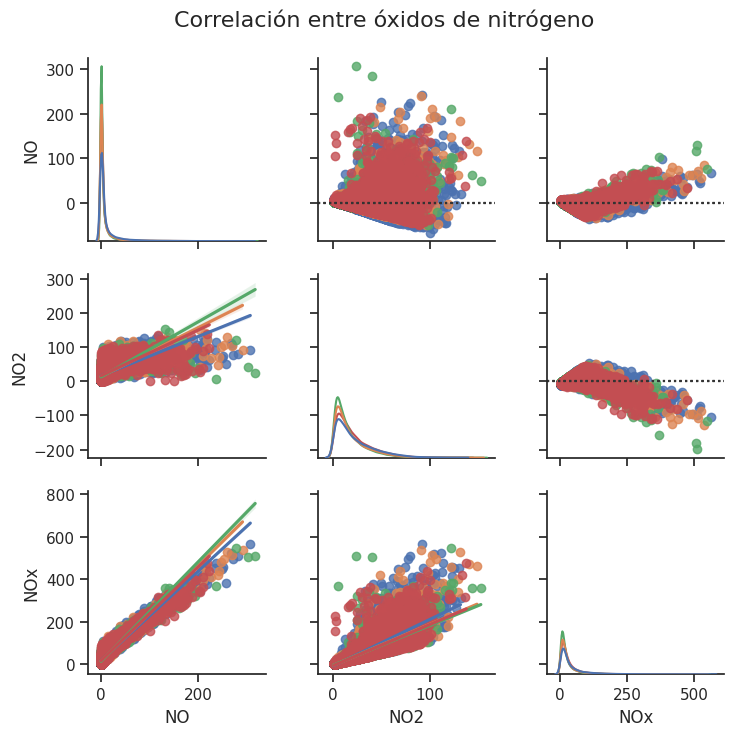

In [11]:
g = sns.PairGrid(_df.reset_index(), vars=["NO","NO2","NOx"],hue="Season")
plt.suptitle('Correlación entre óxidos de nitrógeno', fontsize=16)
plt.tight_layout()
g.map_diag(sns.kdeplot)
g.map_lower(sns.regplot)
g.map_upper(sns.residplot)
plt.show()

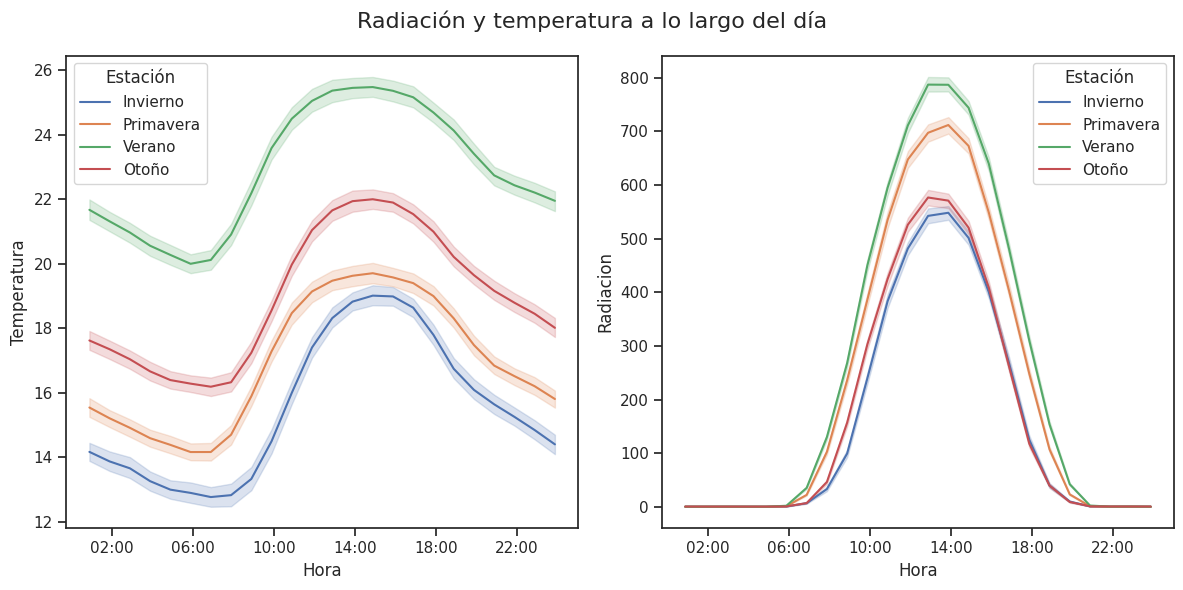

In [12]:

fig, (ax,ax1) = plt.subplots(figsize=(12,6),ncols=2)
fig.suptitle('Radiación y temperatura a lo largo del día', fontsize=16)
sns.lineplot(_df.reset_index(),y="Temperatura",x="timedelta",ax = ax,hue="Season")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_major_locator(mdates.HourLocator(interval=4))
ax.set_xlabel("Hora")
ax.legend(title="Estación")

sns.lineplot(_df.reset_index(),y="Radiacion",x="timedelta",ax = ax1,hue="Season")
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax1.xaxis.set_major_locator(mdates.HourLocator(interval=4))
ax1.set_xlabel("Hora")
ax1.legend(title="Estación")

plt.tight_layout()
plt.show()